# Duplicate Image Detector

The aim of the program is to find the duplicate images in the given directory and remove the images of the duplicate is found. It is important to check for duplicate images in the directory before we implement our Machine Learning model. If there are identical images then the bias comes into play and the performance of the model gets detoriated. So, we perform a preprocessing step to remove the duplicates in the image data. To perform so, here a group of functions are defined that helps to achieve the task to be performed.

### Importing Libraries

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import imutils
from tkinter import *
from tkinter import filedialog
import tkinter
from random import randint
from tqdm import tqdm
from time import sleep

I have implemented tkinter function to select the Data Directoy. It pops-up an interactive drop down menu and we can select the directory we want.

In [2]:
root = Tk()
root.geometry('200x200')


''

In [3]:
#pops up a window to select the directory required
data_dir = tkinter.filedialog.askdirectory(parent = root,initialdir='D:/',title ='Select the directory')


In [4]:
root.destroy()

Here the images that are provided are in the directory named as c23

In [5]:
print(data_dir)
os.chdir(data_dir)

D:/deep learning/c23


### Function to read all the images the Data Directory. Outputs of the function are images and names of the files.

In [6]:
def images_from_directory(data_dir):
    global images
    images = []
    files = [file for file in os.listdir(data_dir) if file.endswith('.png')]
    
    # reads all image files in .png format and convert them to RGB
    
    for i in range(len(files)):
        img = cv2.imread(str(files[i]),1)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        images.append(img)
        
    return images,files
    

In [7]:
images,files = images_from_directory(data_dir)

In [8]:
print(len(images))
#print(files)

484


Getting stats of the image shape 

In [9]:
img_shape = images[0].shape
h = img_shape[0]
w = img_shape[1]
print(' Image Width is {} and Image Heighut is {} '.format(w,h))


 Image Width is 1920 and Image Heighut is 1080 


### Function to visualize the image from the directory

In [10]:
def image_visualization(num):
    
    plt.imshow(images[num])
    plt.title(files[num])
    plt.axis('off')
    

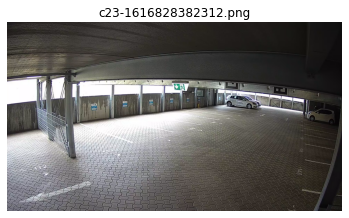

In [11]:
num = randint(0,len(images)-1)
image_visualization(num)

### Function to zero-pad image borders to remove unwanted information 

In [12]:
def draw_color_mask(img, borders, color=(0, 0, 0)):

    h = img.shape[0]

    w = img.shape[1]



    x_min = int(borders[0] * w / 100)

    x_max = w - int(borders[2] * w / 100)

    y_min = int(borders[1] * h / 100)

    y_max = h - int(borders[3] * h / 100)



    img = cv2.rectangle(img, (0, 0), (x_min, h), color, -1)

    img = cv2.rectangle(img, (0, 0), (w, y_min), color, -1)

    img = cv2.rectangle(img, (x_max, 0), (w, h), color, -1)

    img = cv2.rectangle(img, (0, y_max), (w, h), color, -1)



    return img

### Function to convert the image and apply gaussian blur to smooth the image

In [13]:
def preprocess_image_change_detection(img, gaussian_blur_radius_list=None, black_mask=(5, 10, 5, 0)):

    gray = img.copy()

    gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)

    if gaussian_blur_radius_list is not None:

        for radius in gaussian_blur_radius_list:

            gray = cv2.GaussianBlur(gray, (radius, radius), 0)



    gray = draw_color_mask(gray, black_mask)



    return gray

### Function to compare two images from the Data Directory and give the score

In [14]:
def compare_frames_change_detection(prev_frame, next_frame, min_contour_area):

    frame_delta = cv2.absdiff(prev_frame, next_frame)

    thresh = cv2.threshold(frame_delta, 45, 255, cv2.THRESH_BINARY)[1]



    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,

                            cv2.CHAIN_APPROX_SIMPLE)

    cnts = imutils.grab_contours(cnts)



    score = 0

    res_cnts = []

    for c in cnts:

        if cv2.contourArea(c) < min_contour_area:

            continue



        res_cnts.append(c)

        score += cv2.contourArea(c)



    return score, res_cnts, thresh

The step below is performed to check the small areas in the image so that a threshold value can be used to eliminate all small areas in the image. Advanatage of this step is we can eliminate many small contours in the image for min_contour_area computation.

1732 0


(array([3.066e+03, 9.400e+01, 2.500e+01, 1.400e+01, 9.000e+00, 5.000e+00,
        3.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
         550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
        1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600,
        1650, 1700]),
 <BarContainer object of 34 artists>)

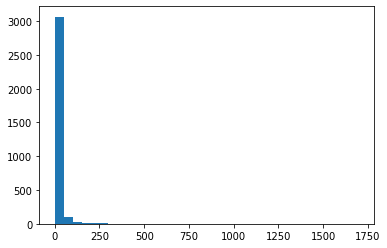

In [15]:
#takes the fist image
img = images[0]
#preprocess it using the function defined above and apply adaptivethreshold
img = preprocess_image_change_detection(img, gaussian_blur_radius_list =[5],black_mask =(5,10,5,0))

thresh = cv2.adaptiveThreshold(img.copy(),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,21,21)
#finds contours and grabs them
cnts = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

#calculates contour area of each contour in image
areas = []
for c in cnts :
    area = cv2.contourArea(c)
    areas.append(area)

average = np.mean(areas)
areas = np.array(areas)

max_val = np.argmax(areas)
min_val = np.argmin(areas)
print(max_val, min_val)
plt.hist(areas,bins = [i for i in range(min_val, max_val,50)])


It is clear from the histogram that most of the small values are close to zero. So we can take a small value near 0.

In [16]:
small_areas = []
for i in range(len(areas)):
    if 0<areas[i]<=10:
        small_areas.append(areas)

From the stats it is clear that more than 40% of areas are small than 10 so excluding them helps for fast calculation.

In [17]:
print(len(small_areas))
small_areas_percent = len(small_areas)/len(areas)
print(small_areas_percent)

1440
0.4445816610064835


In [18]:
image = images[0]

gauss_rad3 = image.copy()
gray_gauss_rad3 = preprocess_image_change_detection(gauss_rad3, gaussian_blur_radius_list =[5],black_mask =(5,10,5,0))

gauss_rad5 = image.copy()
gray_gauss_rad5 = preprocess_image_change_detection(gauss_rad5, gaussian_blur_radius_list =[5],black_mask =(5,10,5,0))

gauss_rad7 = image.copy()
gray_gauss_rad7 = preprocess_image_change_detection(gauss_rad5, gaussian_blur_radius_list =[5],black_mask =(5,10,5,0))


(-0.5, 1919.5, 1079.5, -0.5)

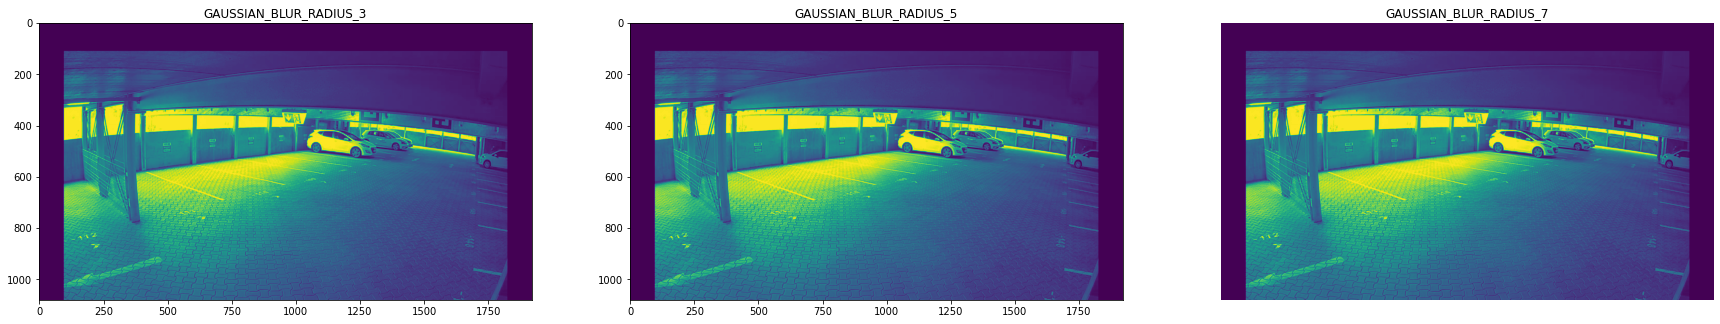

In [19]:
plt.figure(figsize=(30,30))
plt.subplot(1,3,1)
plt.title('GAUSSIAN_BLUR_RADIUS_3')
plt.imshow(gray_gauss_rad3)

plt.subplot(1,3,2)
plt.title('GAUSSIAN_BLUR_RADIUS_5')
plt.imshow(gray_gauss_rad5)

plt.subplot(1,3,3)
plt.title('GAUSSIAN_BLUR_RADIUS_7')

plt.imshow(gray_gauss_rad7)
plt.axis('off')

As it can be seen from above figure that radius 3 is not smoothing image better and radius 7 is smoothing too heavy. So the value of 5 is taken as gaussian_blue_radius.

#### Initialize the required variables

In [20]:
gaussian_blur_radius_list = [5]
min_contour_areas_list = []
duplicate_images_list = []

### Function to calculate contour areas in a single Image

In [21]:
def image_contour(image):
    
    thresh = cv2.adaptiveThreshold(image.copy(),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,21,21)
    
    #plt.imshow(thresh)
    
    cnts = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    cnts = imutils.grab_contours(cnts)
    
    areas = []
    
    for c in cnts:
        area = cv2.contourArea(c)
        # threshold of 10 is set for the area to exclude small areas
        if area > 10:
            areas.append(area)
    
    average = np.mean(areas)
    
    return average

### Function to convert all images to gray scale by applying Gaussian Blur

In [22]:
def image_to_gray(images,gaussian_blur_radius_list):
    
    gray_images = []
    
    for i in range(len(images)):
        
        img = images[i].copy()
        
        gray = preprocess_image_change_detection(img,gaussian_blur_radius_list = gaussian_blur_radius_list)
        
        gray_images.append(gray)
        
    return gray_images
    

We are converting images and preprocessing them before hand as it greatly reduces computational effort for min_contour_area calculation and image comparison steps.

In [23]:
gray_images = image_to_gray(images,gaussian_blur_radius_list)

print(len(gray_images))

484


Computing min_contour_areas and appending to a list

In [24]:
for i in range(len(gray_images)):    
    
    gray = gray_images[i]
    
    min_contour_area = image_contour(gray)
    
    min_contour_areas_list.append(min_contour_area)
    

In [25]:
#initializing the lists
comp_list = []
scores = []

for i in tqdm(range(len(gray_images)-1)):
    
    for j in range(i+1,len(gray_images)):
        
        if i != j and((i,j) or (j,i) not in comp_list):
            # here we get only unique comparisons i.e comparing image 1 to image 2 and image 2 to image 1 are same. 
            # we eliminate comparing image 2 and image 1 as image 1 and 2 are already compared.
            
            prev_frame = gray_images[i].copy()
            next_frame = gray_images[j].copy()
            
            # we are taking file names along with image files 
            prev_frame_name = files[i]
            next_frame_name = files[j]
            
            # getting the contour areas that are calcuated in hand before comparison. Helps to reduce computation time
            
            min_contour_area = (min_contour_areas_list[i] + min_contour_areas_list[j]) / 2
            
            score,res_cnts,thresh = compare_frames_change_detection(prev_frame, next_frame, min_contour_area= min_contour_area)
            
            scores.append(score)
            
            
            count = 0
            if score == 0 and min_contour_areas_list[i] == min_contour_areas_list[j]:
                
                count += 1
                if count>0:
                    print('Duplicate Image found---  Image{} and Image{} are same'.format(files[i],files[j]))
                    
                    # Duplicate Image names are appended to a list
                    if prev_frame_name not in duplicate_images_list:
                        duplicate_images_list.append(prev_frame_name)
            
            comp_list.append((i,j))



100%|██████████████████████████████████████████████████████████████████████████████| 484/484 [1:03:45<00:00,  7.90s/it]


In [26]:
print(duplicate_images_list)

[]


If the length of duplicate_images_list is not 0 then we are removing the duplicate images from the Data Directory

In [28]:
if len(duplicate_images_list)>0:
    
    for i in range(len(duplicate_images_list)):
        
        os.remove(duplicate_images_list[i])

### Test for debugging

In [31]:
d_dir = 'D:\deep learning\kopernikus\c23'
os.chdir(d_dir)

In [44]:
im,f = images_from_directory(d_dir)

g_images = image_to_gray(images,gaussian_blur_radius_list)

print(len(g_images))
print(f)


8
['c23-1616689734969 - Copy.png', 'c23-1616689734969.png', 'c23-1616693502261 - Copy.png', 'c23-1616693502261.png', 'c23-1616694187388 - Copy.png', 'c23-1616694187388.png', 'c23-1616695214951.png', 'c23-1616695557277.png']


In [45]:
min_contour_areas_list1 = []
for i in range(len(g_images)):    
    
    g = g_images[i]
    
    min_contour_area1 = image_contour(g)
    
    min_contour_areas_list1.append(min_contour_area1)

In [60]:
dup_list1 = []


In [73]:
#initializing the lists
c_list = []
sr = []

for i in tqdm(range(len(g_images)-1)):
    
    for j in range(i+1,len(g_images)):
        
        if i != j and((i,j) or (j,i) not in comp_list):
            # here we get only unique comparisons i.e comparing image 1 to image 2 and image 2 to image 1 are same. 
            # we eliminate comparing image 2 and image 1 as image 1 and 2 are already compared.
            
            prev_frame = g_images[i].copy()
            next_frame = g_images[j].copy()
            
            # we are taking file names along with image files 
            prev_frame_name = f[i]
            next_frame_name = f[j]
            # getting the contour areas that are calcuated in hand before comparison. Helps to reduce computation time
            
            min_contour_area = (min_contour_areas_list1[i] + min_contour_areas_list1[j]) / 2
            
            score,res_cnts,thresh = compare_frames_change_detection(prev_frame, next_frame, min_contour_area= min_contour_area)
            
            sr.append(score)
            
            
            count = 0
            if score == 0 and min_contour_areas_list1[i] == min_contour_areas_list1[j]:
                
                count += 1
                if count>0:
                    print('Duplicate Image found---  Image{} and Image{} are same'.format(f[i],f[j]))
                    
                    # Duplicate Image names are appended to a list
                    if prev_frame_name not in dup_list1:
                        dup_list1.append(prev_frame_name)
            
            c_list.append((i,j))



 29%|████████████████████████                                                            | 2/7 [00:00<00:00, 17.30it/s]

Duplicate Image found---  Imagec23-1616689734969 - Copy.png and Imagec23-1616689734969.png are same
Duplicate Image found---  Imagec23-1616693502261 - Copy.png and Imagec23-1616693502261.png are same


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 26.11it/s]

Duplicate Image found---  Imagec23-1616694187388 - Copy.png and Imagec23-1616694187388.png are same


In [72]:
print(dup_list1)

['c23-1616689734969 - Copy.png', 'c23-1616693502261 - Copy.png', 'c23-1616694187388 - Copy.png']
